<a href="https://colab.research.google.com/github/tramyynt/Techlabs/blob/master/Pickshare_Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [133]:
!pip install geopandas
import pandas as pd
import json
import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.graph_objects as go
import geopandas as gpd
import geopy
plt.style.use('seaborn')

import datetime
from datetime import datetime
import calendar

from google.colab import drive
%matplotlib inline

In [ ]:
drive.mount('/drive')

Mounted at /drive


In [122]:
users = pd.read_json('/drive/MyDrive/Techlabs/pickshare_users.json')
# users.head(5)
packages = pd.read_json('/drive/MyDrive/Techlabs/pickshare_packages.json')
packages.head(5)

,senderCompanyName,city,start,end,createdAt,_owner,deliveryDate
0,Amazon,Dortmund,10:00,14:00,2020-07-10T12:40:31.189Z,1,NaN
1,Zoo Royal,Berlin,NaN,NaN,2020-07-21T17:05:11.366Z,31,NaN
2,ABOUTYOU,Dortmund,NaN,NaN,2020-07-22T10:55:39.592Z,1,NaN
3,Test,Berlin,NaN,NaN,2020-07-27T10:22:23.430Z,7,NaN
4,notebooksbilliger.de,Dortmund,1800,2000,2020-08-06T14:47:47.813Z,1,NaN


In [123]:
packages.dropna(inplace=True)
packages.reset_index()

users.dropna(inplace=True)
users.reset_index()

,index,id,firstName,city,role,zip
0,0,0,Franca,Dortmund,1,44139
1,1,1,Björn,Dortmund,1,44139
2,2,2,Julian,Münster,1,48143
3,3,3,Katharina,Dortmund,1,44139
4,4,4,Test Nutzer,Berlin,1,10589
...,...,...,...,...,...,...
324,324,324,Julia,Neuenstein,1,36286
325,325,325,Lena,Berlin,1,14050
326,326,326,Mischa:,oberaula,1,36280
327,327,327,Paul,Mönchengladbach,1,41179


In [124]:
#validate city
def  cleaning_text(df, col):
  df.loc[df[col].str.contains('berlin', case=False, regex=False), col] = 'Berlin'
  df.loc[df[col].str.contains('dortmund', case=False, regex=False), col] = 'Dortmund'
  df.loc[df[col].str.contains('Potsdam', case=False, regex=False), col] = 'Potsdam'
  df.loc[df[col].str.contains('Dusseldorf', case=False, regex=False), col] = 'Düsseldorf'
  df.loc[df[col].str.contains('Regensburg', case=False, regex=False), col] = 'Regensburg'
  df.loc[df[col].str.contains('Moenchengladbach', case = False, regex = False), col] = 'Mönchengladbach'
  df.loc[df[col].str.contains('Bad Hersfeld', case = False, regex = False), col] = 'Bad Hersfeld'
  df.loc[df[col].str.contains('Viersen', case = False, regex = False), col] = 'Viersen'
  df.loc[df[col].str.contains('Münster', case = False, regex = False), col] = 'Münster'
  df.loc[df[col].str.contains('mönchengladbach', case = False, regex = False), col] = 'Mönchengladbach'
  df.loc[df[col].str.contains('Wetzlar', case = False, regex = False), col] = 'Wetzlar'
  df.loc[df[col].str.contains('München', case = False, regex = False), col] = 'München'
  return df

packages = cleaning_text(packages,'city')
users = cleaning_text(users,'city')

In [125]:
#get city list of Germany and check if a city belongs to the list, otherwise remove it. Refer : https://moduliertersingvogel.de/2017/09/03/german-cities-list/
from bs4 import BeautifulSoup
import requests
class CityList:
    def __init__(self):
        self.__countries={
            'BY':'Bayern',
            'BW':'Baden-Württemberg',
            'NW':'Nordrhein-Westfalen',
            'HE':'Hessen',
            'SN':'Sachsen',
            'NI':'Niedersachsen',
            'RP':'Rheinland-Pfalz',
            'TH':'Thüringen',
            'BB':'Brandenburg',
            'ST':'Sachsen-Anhalt',
            'MV':'Mecklenburg-Vorpommern',
            'SH':'Schleswig-Holstein',
            'SL':'Saarland',
            'HB':'Bremen',
            'BE':'Berlin',
            'HH':'Hamburg'
        }
        
    def retrieveGermanList(self):
        r = requests.get('https://de.wikipedia.org/wiki/Liste_der_St%C3%A4dte_in_Deutschland')
        soup = BeautifulSoup(r.content, "html5lib")
        cities={}
        tables=soup.find_all('table')
        for t in tables:
            lis=t.find_all('dd')
            for l in lis:
                # All countries are in brackets after the city name.
                # Some cities are listed like: SN, Landeshauptstadt
                countryShort=None
                additional=l.contents[1].split('(')[1].split(')')[0].strip()
                if ',' in additional:
                    countryShort=additional.split(',')[0]
                else:
                    countryShort=additional
                cities[l.find('a').contents[0]]=self.__countries[countryShort]
                
        return cities

city_list = CityList().retrieveGermanList()
users = users[users['city'].isin(city_list.keys())]
packages = packages[packages['city'].isin(city_list.keys())]

In [126]:
users_per_city = users['city'].value_counts().to_frame().reset_index(drop = False)
users_per_city.columns = ['city', 'number_users']
users_per_city['federal'] = users_per_city['city'].apply(lambda x: city_list[x])
users_per_city['percentage_user'] = users_per_city['number_users']*100/users_per_city['number_users'].sum()

In [127]:
packages.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1709 entries, 18 to 3708
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   senderCompanyName  1709 non-null   object
 1   city               1709 non-null   object
 2   start              1709 non-null   object
 3   end                1709 non-null   object
 4   createdAt          1709 non-null   object
 5   _owner             1709 non-null   int64 
 6   deliveryDate       1709 non-null   object
dtypes: int64(1), object(6)
memory usage: 106.8+ KB


In [128]:
#process datetime values
packages['createdAt'] = packages.createdAt.astype('datetime64')
packages['deliveryDate'] = packages.deliveryDate.astype('datetime64')
packages['createdDate'] = packages.loc[:,'createdAt'].dt.date
packages['createdTime'] = packages.loc[:,'createdAt'].dt.time
packages['delivery_Date'] = packages['deliveryDate'].dt.date
packages['delivery_Time'] = packages['deliveryDate'].dt.time

In [129]:
a = packages['createdTime'].astype(str)
packages['createdTime']=a.apply(lambda x: x[:-7])

In [130]:
b = packages['delivery_Time'].astype(str)
packages['delivery_Time'] = b.apply(lambda x: x[:-7])

In [131]:
packages

,senderCompanyName,city,start,end,createdAt,_owner,deliveryDate,createdDate,createdTime,delivery_Date,delivery_Time
18,Amazon,Berlin,0800,1000,2020-08-19 14:30:35.658,24,2020-08-20 20:41:27.262,2020-08-19,14:30:35,2020-08-20,20:41:27
62,Amazon,Berlin,0800,1000,2020-08-19 14:54:58.316,24,2020-08-20 20:41:27.262,2020-08-19,14:54:58,2020-08-20,20:41:27
80,Amazon,Berlin,1800,2200,2020-08-29 10:25:38.713,27,2020-09-01 09:41:35.091,2020-08-29,10:25:38,2020-09-01,09:41:35
82,Amazon,Berlin,1600,1800,2020-08-28 15:59:19.185,22,2020-08-30 22:38:50.140,2020-08-28,15:59:19,2020-08-30,22:38:50
83,Zoo Royal,Berlin,2000,2200,2020-09-01 11:29:17.865,31,2020-09-01 16:36:20.952,2020-09-01,11:29:17,2020-09-01,16:36:20
...,...,...,...,...,...,...,...,...,...,...,...
3695,Default,Berlin,18,20,2021-10-12 09:31:49.082,61,2021-10-14 15:29:48.449,2021-10-12,09:31:49,2021-10-14,15:29:48
3696,zalando,Dortmund,3,6,2021-10-12 09:43:07.335,57,2021-10-18 09:45:39.303,2021-10-12,09:43:07,2021-10-18,09:45:39
3697,Default,Berlin,16,18,2021-10-12 10:09:35.937,106,2021-10-12 11:09:33.367,2021-10-12,10:09:35,2021-10-12,11:09:33
3705,Default,Berlin,16,18,2021-10-13 11:39:21.041,6,2021-10-15 18:49:04.656,2021-10-13,11:39:21,2021-10-15,18:49:04


In [148]:
#convert datatype of Date field to datetime64
a = packages['createdDate'].astype(str)
b = a.apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
packages['createdDate'] = b
packages['createdDate'].astype('datetime64')

x = packages['delivery_Date'].astype(str)
y = x.apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
packages['delivery_Date'] = y
packages['delivery_Date'].astype('datetime64')

# Create Days
packages['created_Day'] = packages['createdDate'].apply(lambda x: calendar.day_name[x.weekday()])
packages['delivery_Day'] = packages['delivery_Date'].apply(lambda x: calendar.day_name[x.weekday()])

#get diff of createdDate and deliveryDate
packages['diff'] = packages['delivery_Date']- packages['createdDate']

18     2020-08-19
62     2020-08-19
80     2020-08-29
82     2020-08-28
83     2020-09-01
          ...    
3695   2021-10-12
3696   2021-10-12
3697   2021-10-12
3705   2021-10-13
3708   2021-10-13
Name: createdDate, Length: 1709, dtype: datetime64[ns]

In [208]:
packages.head(10)

,senderCompanyName,city,start,end,createdAt,_owner,deliveryDate,createdDate,createdTime,delivery_Date,delivery_Time,created_Day,delivery_Day,diff
18,Amazon,Berlin,0800,1000,2020-08-19 14:30:35.658,24,2020-08-20 20:41:27.262,2020-08-19,14:30:35,2020-08-20,20:41:27,Wednesday,Thursday,1 days
62,Amazon,Berlin,0800,1000,2020-08-19 14:54:58.316,24,2020-08-20 20:41:27.262,2020-08-19,14:54:58,2020-08-20,20:41:27,Wednesday,Thursday,1 days
80,Amazon,Berlin,1800,2200,2020-08-29 10:25:38.713,27,2020-09-01 09:41:35.091,2020-08-29,10:25:38,2020-09-01,09:41:35,Saturday,Tuesday,3 days
82,Amazon,Berlin,1600,1800,2020-08-28 15:59:19.185,22,2020-08-30 22:38:50.140,2020-08-28,15:59:19,2020-08-30,22:38:50,Friday,Sunday,2 days
83,Zoo Royal,Berlin,2000,2200,2020-09-01 11:29:17.865,31,2020-09-01 16:36:20.952,2020-09-01,11:29:17,2020-09-01,16:36:20,Tuesday,Tuesday,0 days
84,Waschbär,Berlin,1800,2000,2020-09-01 11:53:28.724,36,2020-10-02 11:50:54.474,2020-09-01,11:53:28,2020-10-02,11:50:54,Tuesday,Friday,31 days
88,Amazon,Berlin,1600,1800,2020-08-27 12:04:54.077,22,1970-01-01 00:00:00.000,2020-08-27,12:04:54,1970-01-01,0,Thursday,Thursday,-18501 days
90,Waschbär,Berlin,1800,2000,2020-08-31 07:16:11.424,36,2020-10-02 11:50:54.474,2020-08-31,07:16:11,2020-10-02,11:50:54,Monday,Friday,32 days
92,Otto,Dortmund,1900,2100,2020-08-27 12:31:44.606,1,2020-08-28 12:36:15.283,2020-08-27,12:31:44,2020-08-28,12:36:15,Thursday,Friday,1 days
94,Waterdrop,Berlin,2000,2200,2020-09-01 11:56:50.926,20,2020-09-01 15:56:55.159,2020-09-01,11:56:50,2020-09-01,15:56:55,Tuesday,Tuesday,0 days


## Top 5 most ordered senders

In [171]:
#get top 5 senders with most orders
count_bySender = packages.groupby(['senderCompanyName']).size().to_frame('count').sort_values(['count'],ascending = False).head(5)
top5_Sender = count_bySender.iloc[:,0]
top5_Sender = pd.Series(data = top5_Sender.index)

In [235]:
print(type(top5_Sender))

<class 'pandas.core.series.Series'>


No handles with labels found to put in legend.


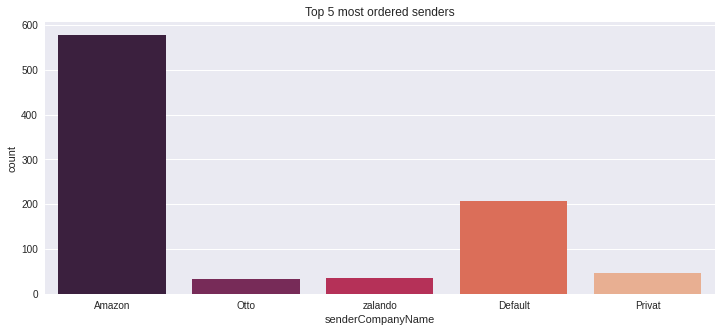

In [244]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))
sns.countplot(data = packages[packages['senderCompanyName'].isin(top5_Sender)],x ='senderCompanyName', palette='rocket')
ax.set_title('Top 5 most ordered senders')
plt.legend()
plt.show()

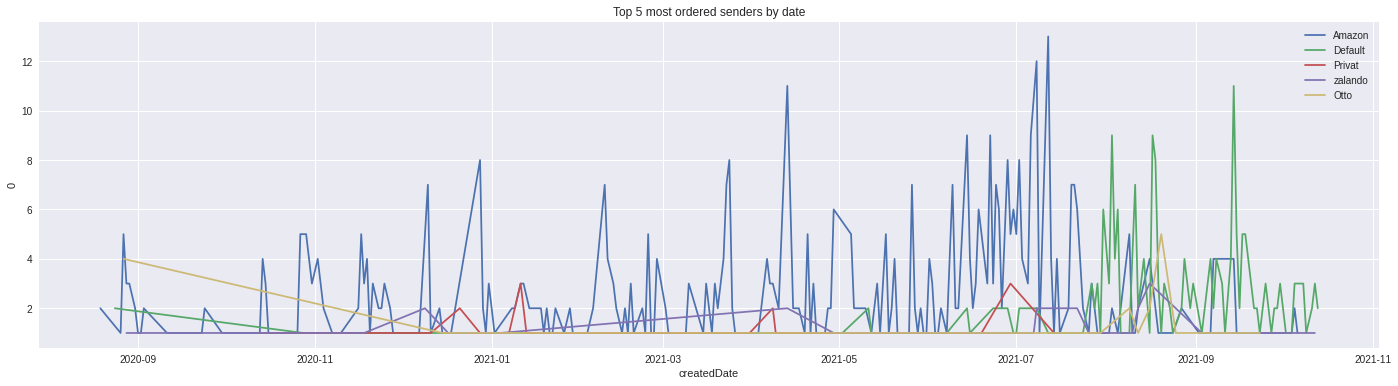

In [211]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(24, 6))
for i in top5_Sender:
  temp = packages[packages.senderCompanyName==i].groupby('createdDate').size().to_frame().reset_index(drop = False)
  sns.lineplot(data=temp, x = temp.createdDate, y= temp[0], label = i, palette='rocket')
ax.set_title('Top 5 most ordered senders by date')
plt.legend()
plt.show()

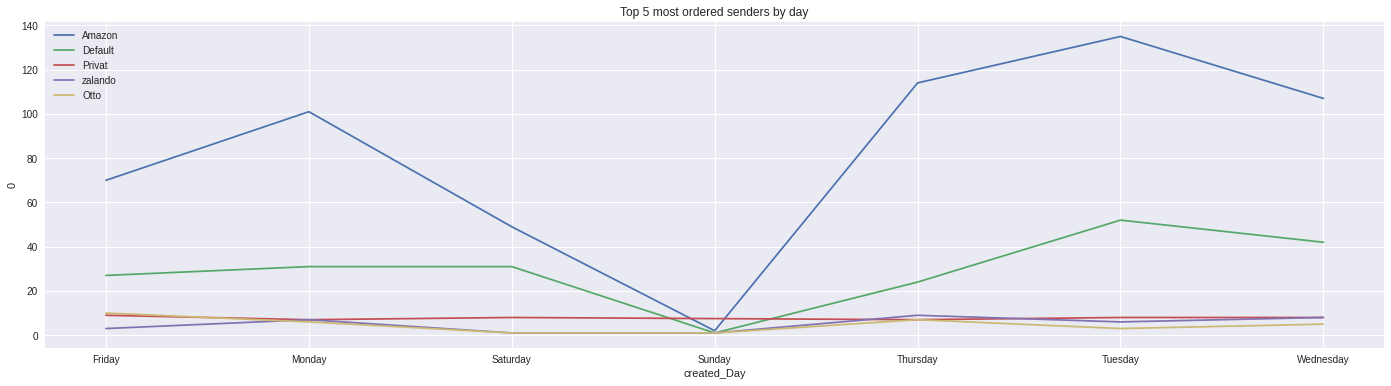

In [210]:
# count by days
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(24, 6))
for i in top5_Sender:
  temp = packages[packages.senderCompanyName==i].groupby('created_Day').size().to_frame().reset_index(drop = False)
  sns.lineplot(data=temp, x = temp.created_Day, y= temp[0], label = i, palette='rocket')
ax.set_title('Top 5 most ordered senders by day')
plt.legend()
plt.show()


## Top 5 cities have the most orders

In [245]:
#get top 5 cities with most orders
count_byCity = packages.groupby(['city']).size().to_frame('count').sort_values(['count'],ascending = False).head(5)
top5_City = count_byCity.iloc[:,0]
top5_City = pd.Series(data = top5_City.index)

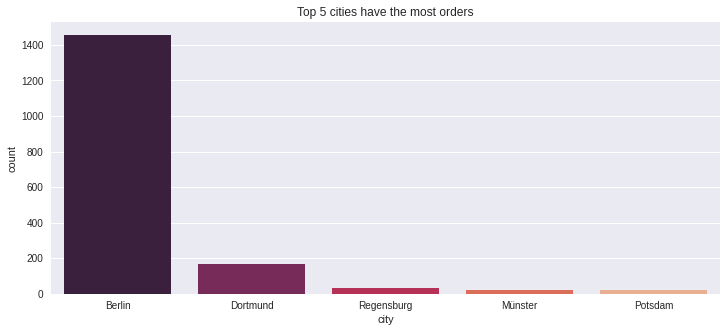

In [248]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))
sns.countplot(data = packages[packages['city'].isin(top5_City)],x ='city', palette='rocket')
ax.set_title('Top 5 cities have the most orders')
plt.show()

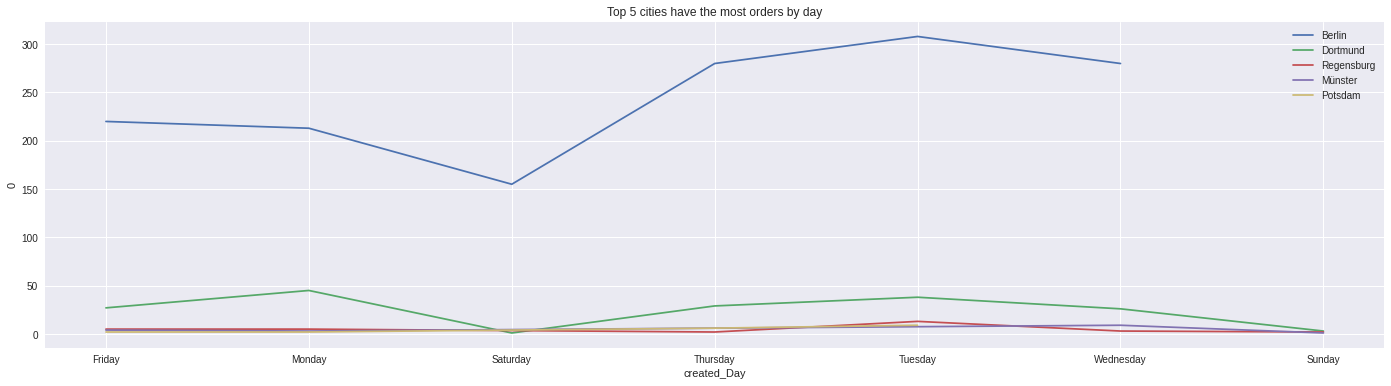

In [249]:
# count by days
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(24, 6))
for i in top5_City:
  temp = packages[packages.city==i].groupby('created_Day').size().to_frame().reset_index(drop = False)
  sns.lineplot(data=temp, x = temp.created_Day, y= temp[0], label = i, palette='rocket')
ax.set_title('Top 5 cities have the most orders by day')
plt.legend()
plt.show()
